In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# **Import**

In [2]:
from glob import glob
import itertools   ## for iterator
import matplotlib.pyplot as plt ##plot grph
import numpy as np ## cal
import os
import pandas as pd ##graph
import PIL ## image
from PIL import Image
import random ##seed
import shutil ##file control
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
import time
from tqdm.notebook import tqdm  ##progress bar


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

In [3]:
# Use cuda(GPU) if possible

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed(539)

In [5]:
##Hyper Parameters
epochs = 100
size = (256, 256)

# DataLoad

In [6]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size, normalize = True):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = dict()
        self.photo_idx = dict()
        
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #RGB == (0.5, 0.5, 0.5)
            ])
            
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()
            ])
        
        #listdir takes all file names in folder by list type
        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl
        
    def __getitem__(self, idx):
        # Get random idx range in (0, idx_length)
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        
        return photo_img, monet_img
    
    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

In [7]:
## Set image Path
img_ds = ImageDataset('../input/gan-getting-started/monet_jpg', '../input/gan-getting-started/photo_jpg', size)

## We don't use batch because I think our data is not that large size
## and don't need to do fast in cost of quality
img_dl = DataLoader(img_ds, batch_size = 1, pin_memory = True)

check if data is properly loaded

In [8]:
## In dataset we do normalize image to (-1, 1)
## for checking real image we need to reverse (=unnorm) to image

def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img

In [9]:
photo_img, monet_img = next(iter(img_dl))

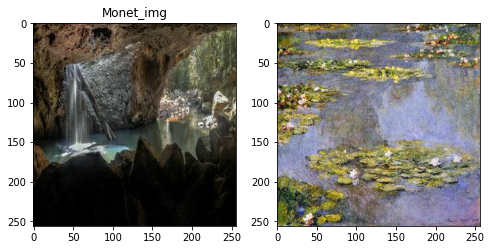

In [10]:
f = plt.figure(figsize = (8,8))

f.add_subplot(1,2,1)
plt.title('Photo_img')
photo_img = unnorm(photo_img)
plt.imshow(photo_img[0].permute(1,2,0))

plt.title('Monet_img')
f.add_subplot(1,2,2)
monet_img = unnorm(monet_img)
plt.imshow(monet_img[0].permute(1,2,0))

# Model

In [11]:
##Upsamling do same like decoder


def Upsample(in_ch, out_ch, use_dropout = True, dropout_ratio = 0.5):
    if use_dropout:
        return nn.Sequential(
        nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1),
        nn.InstanceNorm2d(out_ch),
        nn.Dropout(dropout_ratio),
        nn.GELU()
        )
    else:
        return nn.Sequential(
        nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1),
        nn.InstanceNorm2d(out_ch),
        nn.GELU()
        )

In [12]:
##Label Smoothing for Discriminator
##Error occures in torch 1.7.0 so just dumped
class LabelSmoothingEntropy1(nn.Module):
    def __init__(self, smooth=0.1, reduction='mean', ignore_index=-100):
        super(LabelSmoothingEntropy, self).__init__()
        self.lb_smooth = smooth
        self.reduction = reduction
        self.lb_ignore = ignore_index
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, label):
        # overcome ignored label
        logits = logits.float() # use fp32 to avoid nan
        with torch.no_grad():
            num_classes = logits.size(1)
            label = label.clone().detach()
            ignore = label.eq(self.lb_ignore)
            n_valid = ignore.eq(0).sum()
            label[ignore] = 0
            lb_pos = 1. - self.lb_smooth
            lb_neg = self.lb_smooth / num_classes
            
            print('torch.logit.fill size=', torch.empty_like(logits).fill_(lb_neg).size())
            print('label size =', label.size())
            
            
            lb_one_hot = torch.empty_like(logits).fill_(lb_neg).scatter_(1, label.unsqueeze(1), lb_pos).detach()

        logs = self.log_softmax(logits)
        loss = -torch.sum(logs * lb_one_hot, dim=1)
        loss[ignore] = 0
        if self.reduction == 'mean':
            loss = loss.sum() / n_valid
        if self.reduction == 'sum':
            loss = loss.sum()

        return loss

In [13]:
##Other version of LabelSmoothing
##Error occures in torch 1.7.0 so just dumped

class LabelSmoothingEntropy2(nn.Module):
    def __init__(self):
        super(LabelSmoothingEntropy2, self).__init__()
    def forward(self, x, target, smoothing=0.1):
        confidence = 1. - smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + smoothing * smooth_loss
        return loss.mean()

In [14]:
def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky = 1, use_inst_norm=True, use_pad=True):
    
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)
     
    
    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)
        
        
    if use_leaky == 1:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    elif use_leaky == 2:
        actv = nn.GELU()
    elif use_leaky == 3:
        actv = nn.GELU()
    
    return nn.Sequential(conv, norm, actv)

In [15]:
## Simple model of resnet architecture

class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio = 0.5):
        super().__init__()
        models = list()
        
        
        # size = (256 - 1)/1 + 1 = 256
        models.append(Convlayer(in_features, in_features, 1, 1, use_leaky=3, use_inst_norm=False, use_pad=False))
        
        
        # 256 + 1*2 = 258
        models.append(nn.ReflectionPad2d(1))
        # (258-3)/1 +1 = 256
        models.append(Convlayer(in_features, in_features, 3, 1, use_leaky=2, use_inst_norm=False, use_pad=False))
        
        # 256 + 1*2 = 258
        models.append(nn.ReflectionPad2d(1))
        # (258-3)/1 +1 = 256
        models.append(Convlayer(in_features, in_features, 3, 1, use_leaky=2, use_inst_norm=False, use_pad=False))
        
        self.res = nn.Sequential(*models)
        
    def forward(self, x):
        x = x + self.res(x)
        return x 

In [16]:
class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks= 10):
        super().__init__()
        
        model = list()
        
        
        model.append(nn.ReflectionPad2d(3)) ##262
        
        
        ##inch, outch, kernel_size, stride=2, leaky, inst_norm, padding
        ##model.append(Convlayer(in_ch, 64, 7, 1, use_leaky=2, use_inst_norm=True, use_pad=False)) ## 262-7+1  256
        model.append(nn.Conv2d(in_ch, 64, kernel_size = 7, stride = 1, padding = 0))
        model.append(Convlayer(64,128,4,2, use_leaky=2, use_inst_norm=True, use_pad=True)) ## (256-4+2)/2 +1 = 128
        model.append(Convlayer(128,256,4,2, use_leaky=2, use_inst_norm=True, use_pad=True)) ## (128-4+2)/2 +1 = 64
        
        
        for _ in range(num_res_blocks):
            model.append(Resblock(256)) ##64
            model.append(nn.GELU()) ##2015 renet use relu at the end of resblock output(==x+f(x))
        
        
        ##size of ConvTransposed2d = (input-1)*stride - 2*padding + kernel ,and we made kernel=3, stride=2, padding=1
        model.append(Upsample(256, 128)) ## (64-1)*2 -2+3 = 127
        model.append(Upsample(128, 64)) ## (127-1)*2 -2+3 = 253
        
        model.append(nn.ReflectionPad2d(3)) ## 253+6 = 259
        model.append(nn.Conv2d(64, out_ch, kernel_size=4, padding=0)) ## (259+ 0*2 - 4)/1 +1 = 257
        model.append(nn.Tanh())
        
        self.gen = nn.Sequential(*model)
        
    def forward(self, x):
        return self.gen(x)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers = 4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace = True))
        
        for i in range(1, num_layers):
            in_chs = 64*2**(i-1)
            out_chs = in_chs*2
            if i == num_layers -1:
                model.append(Convlayer(in_chs, out_chs,4, 1))
            else:
                model.append(Convlayer(in_chs, out_chs,4, 2))
        
        
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        
        
        self.disc = nn.Sequential(*model)
        
    def forward(self, x):
        return self.disc(x)

In [18]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

In [19]:
def update_req_grad(models, requires_grad = True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [20]:
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()
        
    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [21]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs
        
    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num-self.decay_epochs)/(self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [22]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses = []
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

In [23]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

def save_checkpoint(state, save_path):
    torch.save(state, save_path)

# Cycle Gan

In [24]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr = 2e-4, lmbda = 10, idt_coef = 0.5, decay_epoch = 0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if (decay_epoch > 0) else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        
        #Each pair of Gen, Desc is adversirial so need personal optim, grad 
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.desc_m = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models()
        self.HuberLoss = nn.MSELoss() ##torch.nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0) ##Smooth L1 is Huberloss
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), 
                                                        self.gen_ptm.parameters()),
                                        lr = start_lr, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(),
                                                         self.desc_p.parameters()),
                                         lr = start_lr, betas=(0.5, 0.999))
        
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range (self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            
            #progress bar
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.desc_m, self.desc_p], False)
                self.adam_gen.zero_grad()
                
                #make fake one
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)
                
                #make recycle img
                cycle_monet = self.gen_ptm(fake_photo)
                cycle_photo = self.gen_mtp(fake_monet)
                cycle_loss_monet = self.l1_loss(cycle_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycle_photo, photo_img) * self.lmbda
                
                #for maintain domain
                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                
                
                ##Desc
                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)
                
                real = torch.ones(monet_desc.size()).to(self.device)
                
                adv_loss_monet = self.HuberLoss(monet_desc, real)
                adv_loss_photo = self.HuberLoss(photo_desc, real)
                
                #total Gen loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()
                
                
                #Backward
                total_gen_loss.backward()
                self.adam_gen.step()
                
                update_req_grad([self.desc_m, self.desc_p], True)
                self.adam_desc.zero_grad()
                
                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)
                
                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)
                
                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.ones(monet_desc_fake.size()).to(self.device)
                
                
                ##Dec loss
                monet_desc_real_loss = self.HuberLoss(monet_desc_real, real)
                monet_desc_fake_loss = self.HuberLoss(monet_desc_fake, fake)
                photo_desc_real_loss = self.HuberLoss(photo_desc_real, real)
                photo_desc_fake_loss = self.HuberLoss(photo_desc_fake, fake)
                
                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()
                
                #Backward
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen_mtp': gan.gen_mtp.state_dict(),
                'gen_ptm': gan.gen_ptm.state_dict(),
                'desc_m': gan.desc_m.state_dict(),
                'desc_p': gan.desc_p.state_dict(),
                'optimizer_gen': gan.adam_gen.state_dict(),
                'optimizer_desc': gan.adam_desc.state_dict()
            }
            save_checkpoint(save_dict, 'current.ckpt')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_desc_loss))
      
            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

In [25]:
gan = CycleGAN(3,3,50, device) ##in_ch, out_ch, epochs

In [26]:
# Save before train
save_dict = {
    'epoch': 0,
    'gen_mtp': gan.gen_mtp.state_dict(),
    'gen_ptm': gan.gen_ptm.state_dict(),
    'desc_m': gan.desc_m.state_dict(),
    'desc_p': gan.desc_p.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),
    'optimizer_desc': gan.adam_desc.state_dict()
}

In [27]:
save_checkpoint(save_dict, 'init.ckpt')

In [28]:
gan.train(img_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (1) | Generator Loss:10.078892 | Discriminator Loss:0.475468


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (2) | Generator Loss:8.600903 | Discriminator Loss:0.077581


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (3) | Generator Loss:8.010909 | Discriminator Loss:0.091833


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (4) | Generator Loss:7.716070 | Discriminator Loss:0.070386


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (5) | Generator Loss:7.173679 | Discriminator Loss:0.057339


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (6) | Generator Loss:6.876798 | Discriminator Loss:0.055385


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (7) | Generator Loss:6.866241 | Discriminator Loss:0.064590


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (8) | Generator Loss:6.835654 | Discriminator Loss:0.051653


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (9) | Generator Loss:6.727967 | Discriminator Loss:0.063957


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (10) | Generator Loss:6.672762 | Discriminator Loss:0.039969


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (11) | Generator Loss:6.702800 | Discriminator Loss:0.050916


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (12) | Generator Loss:6.259529 | Discriminator Loss:0.054788


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (13) | Generator Loss:6.006486 | Discriminator Loss:0.044849


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (14) | Generator Loss:5.858564 | Discriminator Loss:0.044423


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (15) | Generator Loss:5.862626 | Discriminator Loss:0.045105


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (16) | Generator Loss:5.863336 | Discriminator Loss:0.046295


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (17) | Generator Loss:5.721314 | Discriminator Loss:0.039232


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (18) | Generator Loss:5.795359 | Discriminator Loss:0.040590


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (19) | Generator Loss:5.637873 | Discriminator Loss:0.045888


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (20) | Generator Loss:5.615983 | Discriminator Loss:0.033588


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (21) | Generator Loss:5.550601 | Discriminator Loss:0.038576


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (22) | Generator Loss:5.544332 | Discriminator Loss:0.047898


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (23) | Generator Loss:5.567415 | Discriminator Loss:0.029751


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (24) | Generator Loss:5.456376 | Discriminator Loss:0.056034


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (25) | Generator Loss:5.363121 | Discriminator Loss:0.027766


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (26) | Generator Loss:5.321446 | Discriminator Loss:0.036441


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (27) | Generator Loss:5.266551 | Discriminator Loss:0.024201


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (28) | Generator Loss:5.256258 | Discriminator Loss:0.026211


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (29) | Generator Loss:5.090235 | Discriminator Loss:0.024997


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (30) | Generator Loss:5.025298 | Discriminator Loss:0.016817


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (31) | Generator Loss:5.024102 | Discriminator Loss:0.017908


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (32) | Generator Loss:5.099453 | Discriminator Loss:0.015350


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (33) | Generator Loss:4.746600 | Discriminator Loss:0.015334


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (34) | Generator Loss:4.764081 | Discriminator Loss:0.013672


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (35) | Generator Loss:4.698616 | Discriminator Loss:0.010397


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (36) | Generator Loss:4.680108 | Discriminator Loss:0.008813


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (37) | Generator Loss:4.623681 | Discriminator Loss:0.008350


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (38) | Generator Loss:4.467232 | Discriminator Loss:0.008263


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (39) | Generator Loss:4.357829 | Discriminator Loss:0.006976


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (40) | Generator Loss:4.315399 | Discriminator Loss:0.006381


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (41) | Generator Loss:4.285423 | Discriminator Loss:0.003938


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (42) | Generator Loss:4.236824 | Discriminator Loss:0.003957


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (43) | Generator Loss:4.189321 | Discriminator Loss:0.003102


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (44) | Generator Loss:4.174114 | Discriminator Loss:0.002685


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (45) | Generator Loss:4.012361 | Discriminator Loss:0.002445


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (46) | Generator Loss:3.967131 | Discriminator Loss:0.001982


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (47) | Generator Loss:4.016473 | Discriminator Loss:0.001609


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (48) | Generator Loss:3.884018 | Discriminator Loss:0.001475


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (49) | Generator Loss:3.849431 | Discriminator Loss:0.001292


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (50) | Generator Loss:3.844565 | Discriminator Loss:0.001087


In [29]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir, size=(256,256), normalize = True):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()
            ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl
            
    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return photo_img
    
    def __len__(self):
        return len(self.photo_idx.keys())

In [30]:
photo_ds = PhotoDataset('../input/gan-getting-started/photo_jpg')
photo_dl = DataLoader(photo_ds, batch_size =1, pin_memory=True)

In [31]:
!mkdir ../images

trans = transforms.ToPILImage()

t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())

for i,photo in enumerate(t):
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()
        pred_monet = unnorm(pred_monet)
        img = trans(pred_monet[0]).convert('RGB')
        img.save('../images/' + str(i+1) + '.jpg')

  0%|          | 0/7038 [00:00<?, ?it/s]

In [32]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")


'/kaggle/working/images.zip'

In [33]:
'''
-------------------
괜찮았던 것

++ epoch만 늘려서 도전(epoch50 일때 Gen_loss : 3.72정도였음 / epoch80일때 Gen_loss=3.1)
+ --resnet 끝에 gelu 붙임 -> loss가 수렴하는 속도가 빨라지는듯
+ Generator에 resblock 수 늘이기
+ Not using InstanceNorm at the first layer of both generator and discriminator
+- MSE error 에서 Huber loss 로 변경하고 더 경사도 죽인후 변경 후 epoch 늘려서 충분히 학습하기


공부할 것
dropout 조정(https://hr-hr.facebook.com/groups/TensorFlowKR/permalink/789796841361376/) -> concrete dropout

Discriminator 에 Label smoothing 적용해보기 (MSE error 대신 LabelSmoothingEntropy loss 씀) -> pytorch version 오류 뜨는듯
mixup 은 생각보다 효과 별로 없다는 얘기가 많아서 보류

-----------------


'''

'\n-------------------\n괜찮았던 것\n\n++ epoch만 늘려서 도전(epoch50 일때 Gen_loss : 3.72정도였음 / epoch80일때 Gen_loss=3.1)\n+ --resnet 끝에 gelu 붙임 -> loss가 수렴하는 속도가 빨라지는듯\n+ Generator에 resblock 수 늘이기\n+ Not using InstanceNorm at the first layer of both generator and discriminator\n+- MSE error 에서 Huber loss 로 변경하고 더 경사도 죽인후 변경 후 epoch 늘려서 충분히 학습하기\n\n\n공부할 것\ndropout 조정(https://hr-hr.facebook.com/groups/TensorFlowKR/permalink/789796841361376/) -> concrete dropout\n\nDiscriminator 에 Label smoothing 적용해보기 (MSE error 대신 LabelSmoothingEntropy loss 씀) -> pytorch version 오류 뜨는듯\nmixup 은 생각보다 효과 별로 없다는 얘기가 많아서 보류\n\n-----------------\n\n\n'

-https://www.kaggle.com/nachiket273/cyclegan-pytorch

-https://www.kaggle.com/dimitreoliveira/improving-cyclegan-monet-paintings

-https://www.youtube.com/watch?v=T54ouYCsawQ